In [1]:
%matplotlib inline

In [2]:
pwd

'C:\\Users\\alferreira\\Documents\\stocks\\prototypes'

In [3]:
cd ..

C:\Users\alferreira\Documents\stocks


In [4]:
from matplotlib import pyplot as plt
import os
import sys
import pandas as pd
import numpy as np
import struct
import datetime
import calendar
import time
import argparse
import seaborn as sns
from algos.util import progressbar
from algos import meta5Ibov
import scipy
import random
from numba import njit, prange

In [5]:
import os

if os.name == 'nt':
    meta5Ibov.setDataPath(r'C:\Users\alferreira\Documents\stocks\data', 
                        r'C:\Users\alferreira\Documents\stocks\data')
else:
    meta5Ibov.setDataPath(r'/home/andre/Projects/stocks/data', 
                        r'/home/andre/Projects/stocks/data')

Master data loaded size (minutes):  503496
symbols loaded:
['ABEV3' 'B3SA3' 'BBAS3' 'BBDC4' 'DOL$' 'ITUB4' 'PETR4' 'VALE3' 'WIN@']


In [6]:
meta5Ibov.loadMeta5Data();

Master data loaded size (minutes):  503496
symbols loaded:
['ABEV3' 'B3SA3' 'BBAS3' 'BBDC4' 'DOL$' 'ITUB4' 'PETR4' 'VALE3' 'WIN@']
Using previous loaded data!


In [7]:
prices = meta5Ibov.getSymbol('WIN@')

In [8]:
prices.RV = np.log(prices.RV+100)  # to log scale

Last 21 business days

In [9]:
len(prices)

503496

In [10]:
start = np.random.randint(400000)

In [11]:
prices = prices[start:start+5*7*60]

In [12]:
prices.head(2)

,O,H,L,C,TV,S,RV
time,,,,,,,
2016-03-04 13:21:00,61997.0,62015.0,61953.0,61997.0,499,1,7.113956
2016-03-04 13:22:00,62003.0,62028.0,61959.0,62003.0,349,1,6.911747


Best 1D use of Gaussian Mixture Model Example 

http://www.astroml.org/book_figures/chapter4/fig_GMM_1D.html

To use Gaussian Mixture Model on a 1D array of price values the interval between prices MUST  
be continuous, equal to `tick_value`. To solve create continuous index with `tick_value` interval from min and max price. 

In [13]:
prices = prices.C.values

In [14]:
tick_value = 5
price_min = np.min(prices)-(np.min(prices)%tick_value)
price_max = np.max(prices)-(np.max(prices)%tick_value)+tick_value
assert(price_min%tick_value==0 and price_max%tick_value==0)
new_prices = np.arange(price_min, price_max+tick_value, tick_value)
# first and last value must be divisible by tick_value

### Using BIC or AIC Information Criteria to select the best number of componnents

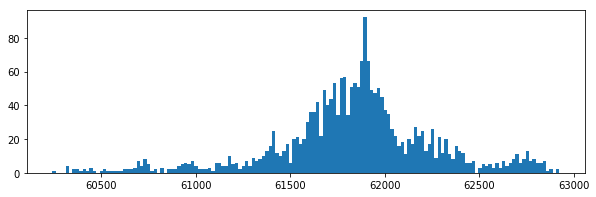

In [15]:
plt.figure(figsize=(10,3))
plt.hist(prices, bins=150);

In [16]:
from sklearn.mixture import GaussianMixture as gmm
from scipy.optimize import curve_fit
from scipy.stats import norm
from sklearn.cluster import KMeans, MeanShift
from sklearn.neighbors import KernelDensity as kd

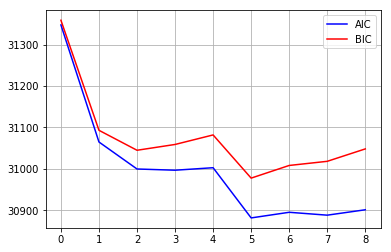

In [17]:
# fit models with 1-14 components
N = np.arange(1, 10)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = gmm(N[i]).fit(prices[:, np.newaxis])

# compute the AIC and the BIC
AIC = [m.aic(prices[:, np.newaxis]) for m in models]
BIC = [m.bic(prices[:, np.newaxis]) for m in models]

plt.plot(AIC, 'b-', label='AIC')
plt.plot(BIC, 'r-', label='BIC')
plt.legend()
plt.grid()

In [18]:
M_best = models[min(np.argmin(BIC), np.argmin(AIC))] # min on both

Gaussians Fitted mean and variance

In [19]:
for i in range(len(M_best.covariances_)):
    mean, var = M_best.means_[i], M_best.covariances_[i]
    print(mean, var)

[61691.40870401] [[9506.36700151]]
[62242.23196355] [[15954.26206363]]
[60824.37547347] [[68037.92432154]]
[62713.93746866] [[9238.37353955]]
[61910.73052544] [[7333.89181544]]
[61396.3589971] [[18974.97614658]]


In [20]:
M_best.tol

0.001

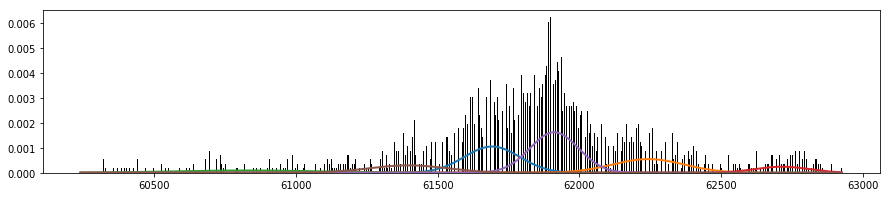

In [21]:
x = np.linspace(np.min(prices), np.max(prices), len(prices))

plt.figure(figsize=(15,3))
plt.hist(prices, bins=1000, density=True, color='k');

for i in range(len(M_best.covariances_)):
    mean, var = M_best.means_[i], M_best.covariances_[i]
    gaussn = norm(loc=mean, scale=np.sqrt(var))
    plt.plot(x, gaussn.pdf(x)[0]*M_best.weights_[i], lw=2)

#### Get params for each gaussian 

In [22]:
means, variances, weights = M_best.means_, M_best.covariances_.flatten(), M_best.weights_

In [23]:
means, variances, weights

(array([[61691.40870401],
        [62242.23196355],
        [60824.37547347],
        [62713.93746866],
        [61910.73052544],
        [61396.3589971 ]]),
 array([ 9506.36700151, 15954.26206363, 68037.92432154,  9238.37353955,
         7333.89181544, 18974.97614658]),
 array([0.25664115, 0.17332653, 0.06095295, 0.05853997, 0.34784929,
        0.1026901 ]))

### Drop weights bellow .10 percentil

In [24]:
cut = np.percentile(weights, 10)

In [25]:
cut = np.argwhere(weights > cut).flatten()

In [26]:
cut

array([0, 1, 2, 4, 5], dtype=int64)

In [27]:
means, variances, weights = means[cut], variances[cut], weights[cut]

In [28]:
mparams = np.zeros((len(cut),3))
mparams[:, 0] = means.flatten()
mparams[:, 1] = variances.flatten()
mparams[:, 2] = weights.flatten()

In [29]:
dfmodels = pd.DataFrame(mparams, columns=['mean', 'variance', 'weight'])

In [30]:
dfmodels.sort_values(by='mean', inplace=True)

In [31]:
dfmodels.head()

,mean,variance,weight
2,60824.375473,68037.924322,0.060953
4,61396.358997,18974.976147,0.102690
0,61691.408704,9506.367002,0.256641
3,61910.730525,7333.891815,0.347849
1,62242.231964,15954.262064,0.173327


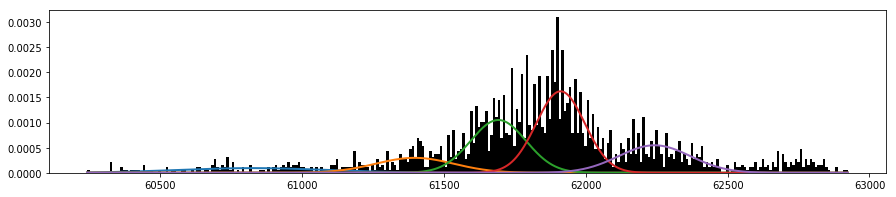

In [32]:
x = np.linspace(np.min(prices), np.max(prices), len(prices))

plt.figure(figsize=(15,3))
plt.hist(prices, bins=300, density=True, color='k');
#dfmodels['gaussn'] = None
for i, row in dfmodels.iterrows():
    mean, var, weight = row[:3]        
    gaussn = norm(loc=mean, scale=np.sqrt(var))
    #dfmodels.loc[i, 'gaussn'] = gaussn
    plt.plot(x, gaussn.pdf(x)*weight, lw=2)

### Class probabilities

In [33]:
from scipy.signal import argrelextrema

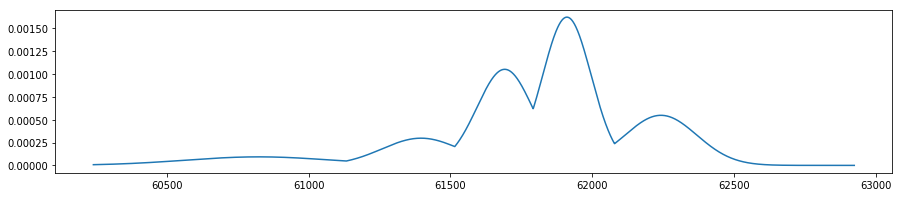

In [34]:
# predicted = M_best.predict_proba(x[:, np.newaxis]);
# for i in range(predicted.shape[1]):
#     plt.plot(x, predicted[:, i], lw=2, alpha=0.8);
combined = np.zeros((len(x), len(weights)))
gaussians = []

for i, row in dfmodels.iterrows():
    mean, var, weight = row[:3]          
    gaussn = norm(loc=mean, scale=np.sqrt(var))
    gaussians.append(gaussn)    
    combined[:, i] = gaussn.pdf(x)*weight
    #plt.plot(x, combined[:, i])

plt.figure(figsize=(15,3))
probs = np.max(combined, axis=1)
plt.plot(x, probs)
bounds = x[argrelextrema(probs, np.less, order=4)]
# add extreme bounds
#bounds = np.sort()
#[gaussians[0].ppf(0.01), gaussians[-1].ppf(0.99)]
bounds = np.sort(np.append([gaussians[0].ppf(0.05), gaussians[-1].ppf(0.95)], bounds))
peaks = x[argrelextrema(probs, np.greater, order=1)]

In [35]:
len(bounds), len(dfmodels)

(6, 5)

In [36]:
# adjust bounds by percentis of every gaussian 1%-99%
dfmodels['b_min'] = 0
dfmodels['b_max'] = 0
for i in range(len(bounds)-1):
    mean, var, weight = dfmodels.iloc[i, :3]          
    gaussn = norm(loc=mean, scale=np.sqrt(var))    
    if bounds[i] < gaussn.ppf(0.01):
         dfmodels.loc[i, 'b_min'] = gaussn.ppf(0.01)
    else:
         dfmodels.loc[i, 'b_min'] = bounds[i]
    if bounds[i+1] > gaussn.ppf(0.99):
        dfmodels.loc[i, 'b_max'] = gaussn.ppf(0.99)
    else:
         dfmodels.loc[i, 'b_max'] = bounds[i+1]

In [37]:
dfmodels

,mean,variance,weight,b_min,b_max
2,60824.375473,68037.924322,0.060953,61515.393044,61791.490233
4,61396.358997,18974.976147,0.102690,62079.091472,62449.993724
0,61691.408704,9506.367002,0.256641,60395.330533,61130.646498
3,61910.730525,7333.891815,0.347849,61791.490233,62079.091472
1,62242.231964,15954.262064,0.173327,61130.646498,61515.393044


In [38]:
bounds = dfmodels.loc[:, ['b_min', 'b_max']].values.flatten()

#### Water-flow style

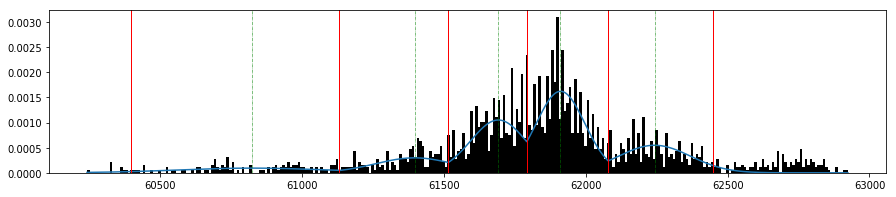

In [39]:
plt.figure(figsize=(15,3))
plt.hist(prices, bins=300, density=True, color='k');
plt.plot(x, probs)
for xc in bounds.flatten():
    plt.axvline(x=xc, color='r', lw=1.)
for xc in peaks.flatten():
    plt.axvline(x=xc, color='g', ls='-.', lw=0.5)

Turning in classes d

In [40]:
kde = kd(kernel='gaussian', bandwidth=20).fit(prices[:, np.newaxis])
#kde = kd(kernel='exponential', bandwidth=25).fit(prices[:, np.newaxis])

In [41]:
density = np.exp(kde.score_samples(x[:, np.newaxis]))

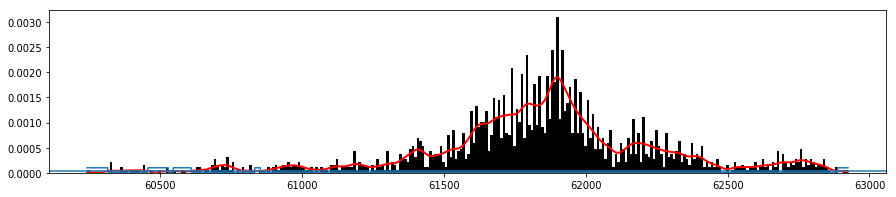

In [42]:
plt.figure(figsize=(15,3))
plt.hist(prices, bins=300, density=True, color='k');
plt.plot(x, density, 'r', lw=2)
plt.axhline(np.percentile(density, 10)) # bellow most likely no data
nodata = np.ones(len(density))*(density < np.percentile(density, 10))
plt.plot(x, nodata*1e-4)

In [43]:
import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=200)
    
def plot_density(prices):
    kde = kd(kernel='gaussian', bandwidth=30).fit(prices[:, np.newaxis])
    x = np.linspace(np.min(prices), np.max(prices), len(prices))
    log_dens = np.exp(kde.score_samples(x[:, np.newaxis]))
    # Three subplots sharing both x/y axes
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=True, gridspec_kw = {'width_ratios':[8, 1]},
                                 figsize=(15,4))
    ax1.plot(prices)
    ax1.yaxis.set_major_locator(loc)
    ax1.grid()
    ax2.fill(np.exp(log_dens), x)
    ax2.grid(axis='y', which='both')
    # Fine-tune figure; make subplots close to each other and hide x ticks for
    # all but bottom plot.
    f.subplots_adjust(wspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[-1:]], visible=False);

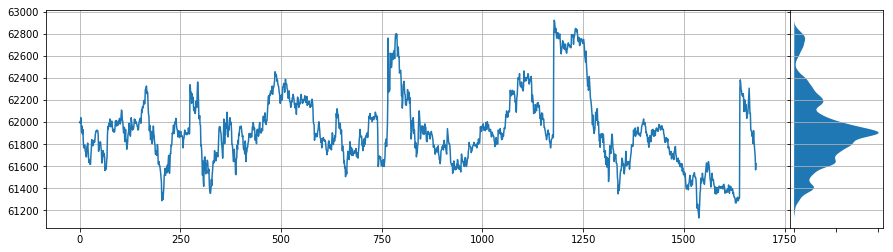

In [48]:
plot_density(prices[:60*7*4])

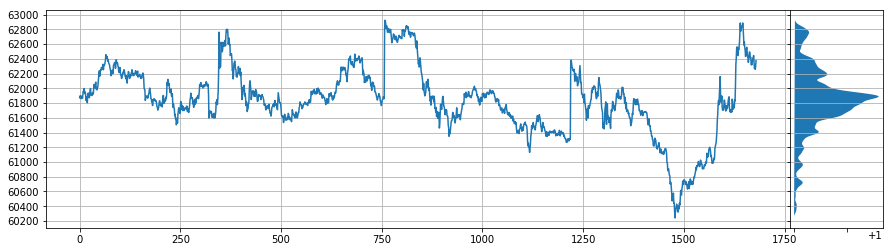

In [47]:
plot_density(prices[-60*7*4:])